# PLANT LEAVES CLASSIFICATION
# Matteo Tarenzi _ 986974

## Build a Neural Network for the classification of leaves images

Help curios people to know more about plants that surround us. The project is divided into two parts:

1. The first part is focused on classifying the type of the plants using the images of their leaves

2. The seconf part is about classifying into healthy and diseased leaves and is inted for people who wants to     detect plants that need care

### Use Kaggle API to download the data set

In [ ]:
import os
import shutil

In [ ]:
os.environ['KAGGLE_USERNAME'] = "xxxx"
os.environ['KAGGLE_KEY'] ="xxxxxx"
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

100% 6.54G/6.56G [00:47<00:00, 243MB/s]
100% 6.56G/6.56G [00:47<00:00, 148MB/s]


In [ ]:
import zipfile

zip_file_path = 'plant-leaves-for-image-classification.zip'
extract_path = '.'

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.remove('plant-leaves-for-image-classification.zip')

In [ ]:
#Create a copy for the second part of the project
shutil.copytree("Plants_2", "Health")

'Health'

In [ ]:
os.listdir("Plants_2")

['valid', 'test', 'train', 'images to predict']

In [ ]:
#These are 3 functions used to prepare the data set for the first part of the project

#1.Function used to merge the healthy and the diseased leaves based on the plant type
def prepare_div(folder):

    subdirectories = os.listdir(folder)
    plant_directories = {}


    for subdirectory in subdirectories:
        plant_name = subdirectory.split(" ")[0]
        if plant_name not in plant_directories:
            plant_directories[plant_name] = []
        plant_directories[plant_name].append(subdirectory)

    # Iterate through the directories and merge their contents
    for plant_name, subdirs in plant_directories.items():
        if len(subdirs) > 1:  # If there's more than one directory
            destination_directory = os.path.join(folder, subdirs[0])
            for subdir in subdirs[1:]:
                source_directory = os.path.join(folder, subdir)
                for item in os.listdir(source_directory):
                    source_item = os.path.join(source_directory, item)
                    destination_item = os.path.join(destination_directory, item)
                    if os.path.isfile(source_item):
                        shutil.move(source_item, destination_item)

#2. Fuction to delete the empty directories
def delet_dir(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir, topdown=False):
        for dirname in dirnames:
            directory_path = os.path.join(dirpath, dirname)
            if not os.listdir(directory_path):
                print(f"Deleting empty directory: {directory_path}")
                os.rmdir(directory_path)


#3. Function to rename the remaining directories to the name of the plant
def rename_dir(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for dirname in dirnames:
            old_dir = os.path.join(dirpath, dirname)
            plant_name = dirname.split(' ')[0]  # Extract the plant name
            new_dir = os.path.join(dirpath, plant_name)
            os.rename(old_dir, new_dir)


# First part: "Plants type classification"  

In [ ]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [ ]:
#Apply this pre-processing to both training, validation and test

directories= ('Plants_2/train','Plants_2/test','Plants_2/valid')

for folder in directories:
    prepare_div(folder)
    delet_dir(folder)
    rename_dir(folder)

Deleting empty directory: Plants_2/train/Arjun diseased (P1a)
Deleting empty directory: Plants_2/train/Chinar healthy (P11a)
Deleting empty directory: Plants_2/train/Jatropha diseased (P6b)
Deleting empty directory: Plants_2/train/Jamun healthy (P5a)
Deleting empty directory: Plants_2/train/Pongamia Pinnata healthy (P7a)
Deleting empty directory: Plants_2/train/Gauva diseased (P3b)
Deleting empty directory: Plants_2/train/Alstonia Scholaris healthy (P2b)
Deleting empty directory: Plants_2/train/Pomegranate diseased (P9b)
Deleting empty directory: Plants_2/train/Mango diseased (P0b)
Deleting empty directory: Plants_2/train/Lemon diseased (P10b)
Deleting empty directory: Plants_2/test/Arjun diseased (P1a)
Deleting empty directory: Plants_2/test/Chinar healthy (P11a)
Deleting empty directory: Plants_2/test/Jatropha diseased (P6b)
Deleting empty directory: Plants_2/test/Jamun healthy (P5a)
Deleting empty directory: Plants_2/test/Pongamia Pinnata healthy (P7a)
Deleting empty directory: Plan

In [ ]:
train_dir = "Plants_2/train"
valid_dir = "Plants_2/valid"
test_dir = "Plants_2/test"


In [ ]:
#Define the size of the images that will be used

img_height=64
img_width=64
BATCH_SIZE=128


## Load the train and the validation set

In [ ]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=True,
    image_size=(img_width,img_height),
    interpolation="bilinear"
)


Found 4274 files belonging to 12 classes.


In [ ]:
valid_ds=tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    shuffle=True,
    image_size=(img_width,img_height),
    interpolation="bilinear"
)


Found 110 files belonging to 12 classes.


In [ ]:
#Check if there's all the classes
class_names = train_ds.class_names
print(class_names)


['Alstonia', 'Arjun', 'Bael', 'Basil', 'Chinar', 'Gauva', 'Jamun', 'Jatropha', 'Lemon', 'Mango', 'Pomegranate', 'Pongamia']


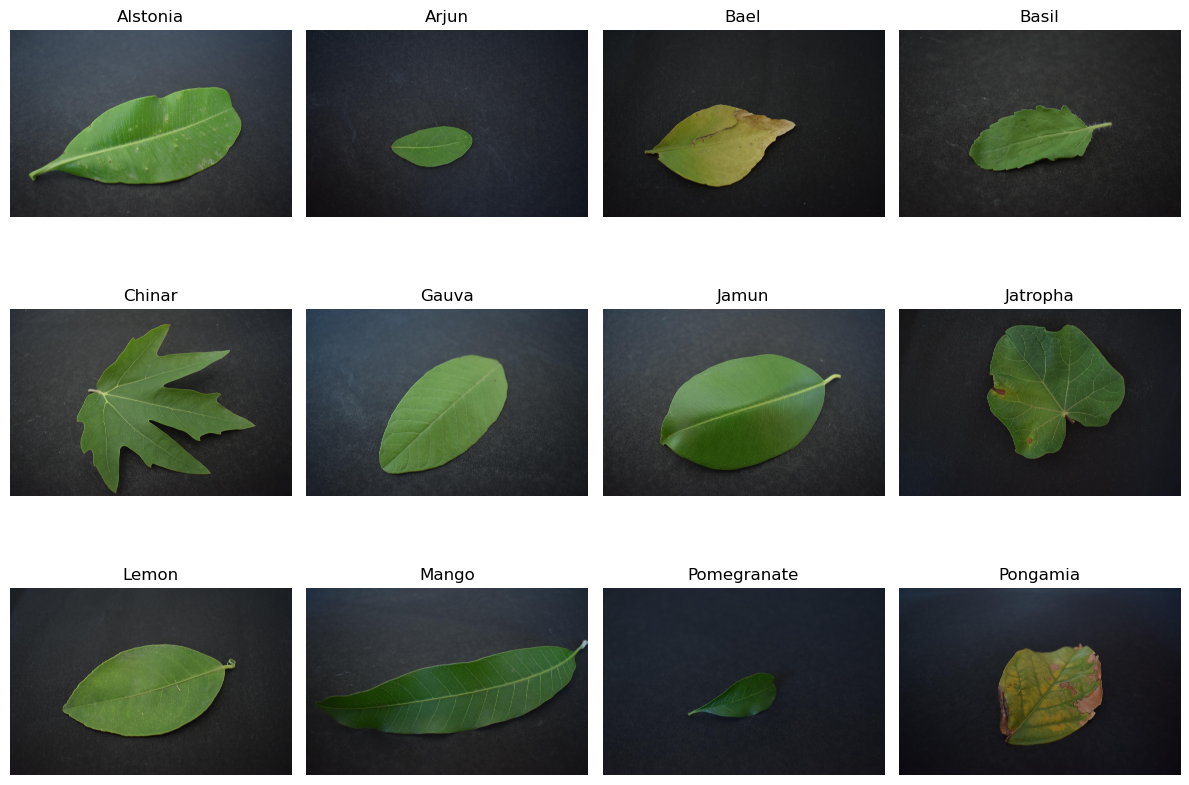

In [ ]:
#Plot one random image for each of the types of plants

import matplotlib.image as mpimg
import random

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.ravel()

for i, directory in enumerate(class_names):

    image_files = os.listdir(f'Plants_2/train/{directory}')

    random_image = random.choice(image_files)

    #Create the path for plotting
    image_path = os.path.join(f'Plants_2/train/{directory}', random_image)

    #Load and plot
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f'{directory}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## The implementation of the model

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(buffer_size=round(4300/BATCH_SIZE)).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
keras.backend.clear_session()

In [ ]:
#Define some data augmentation layers to help with the overfitting

data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1)
  ]
)


In [ ]:
#The model, the optimizer and the loss function

model_div = Sequential([
  layers.Rescaling(1./255, input_shape=(img_width,img_height,3)),
  data_augmentation,
  layers.Conv2D(kernel_size=5,filters=25,activation='relu'),
  layers.AveragePooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(kernel_size=5,filters=50,activation='relu'),
  layers.AveragePooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(kernel_size=4,filters=75,activation='relu'),
  layers.AveragePooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(450,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(350,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(240,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(120,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(60,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(30,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(12,activation='softmax')
 ])

model_div.compile(optimizer=optimizers.legacy.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model_div.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 25)        1900      
                                                                 
 average_pooling2d (Average  (None, 30, 30, 25)        0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 30, 30, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 50)        31300     
                                                      

In [ ]:
# Set a learning decay function
def lr_decay(epoch):
 return 0.00125-(epoch*0.0000025)

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)


In [ ]:
# Set the number of epochs and train the model

EPOCHS=400
history = model_div.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=EPOCHS,
  callbacks=([lr_decay_callback])
)



Epoch 1: LearningRateScheduler setting learning rate to 0.00125.
Epoch 1/400
34/34 [==============================] - 12s 322ms/step - loss: 2.2632 - accuracy: 0.2232 - val_loss: 2.1683 - val_accuracy: 0.1727 - lr: 0.0012

Epoch 2: LearningRateScheduler setting learning rate to 0.0012475000000000001.
Epoch 2/400
34/34 [==============================] - 11s 313ms/step - loss: 1.8849 - accuracy: 0.3362 - val_loss: 1.7691 - val_accuracy: 0.2909 - lr: 0.0012

Epoch 3: LearningRateScheduler setting learning rate to 0.001245.
Epoch 3/400
34/34 [==============================] - 12s 348ms/step - loss: 1.7278 - accuracy: 0.3692 - val_loss: 1.7757 - val_accuracy: 0.2909 - lr: 0.0012

Epoch 4: LearningRateScheduler setting learning rate to 0.0012425000000000001.
Epoch 4/400
34/34 [==============================] - 11s 333ms/step - loss: 1.5694 - accuracy: 0.4436 - val_loss: 1.3527 - val_accuracy: 0.4818 - lr: 0.0012

Epoch 5: LearningRateScheduler setting learning rate to 0.00124.
Epoch 5/400
3

Epoch 37/400
34/34 [==============================] - 11s 322ms/step - loss: 0.9561 - accuracy: 0.7012 - val_loss: 0.8767 - val_accuracy: 0.7364 - lr: 0.0012

Epoch 38: LearningRateScheduler setting learning rate to 0.0011575000000000001.
Epoch 38/400
34/34 [==============================] - 11s 316ms/step - loss: 0.7320 - accuracy: 0.7679 - val_loss: 1.1211 - val_accuracy: 0.6818 - lr: 0.0012

Epoch 39: LearningRateScheduler setting learning rate to 0.001155.
Epoch 39/400
34/34 [==============================] - 11s 323ms/step - loss: 0.6897 - accuracy: 0.7913 - val_loss: 0.7929 - val_accuracy: 0.7727 - lr: 0.0012

Epoch 40: LearningRateScheduler setting learning rate to 0.0011525.
Epoch 40/400
34/34 [==============================] - 11s 327ms/step - loss: 0.6846 - accuracy: 0.7859 - val_loss: 0.8758 - val_accuracy: 0.7182 - lr: 0.0012

Epoch 41: LearningRateScheduler setting learning rate to 0.00115.
Epoch 41/400
34/34 [==============================] - 11s 320ms/step - loss: 0.6853

34/34 [==============================] - 11s 337ms/step - loss: 0.5346 - accuracy: 0.8379 - val_loss: 0.7642 - val_accuracy: 0.8091 - lr: 0.0011

Epoch 74: LearningRateScheduler setting learning rate to 0.0010675.
Epoch 74/400
34/34 [==============================] - 11s 318ms/step - loss: 0.5760 - accuracy: 0.8264 - val_loss: 0.7029 - val_accuracy: 0.8182 - lr: 0.0011

Epoch 75: LearningRateScheduler setting learning rate to 0.001065.
Epoch 75/400
34/34 [==============================] - 11s 326ms/step - loss: 0.5480 - accuracy: 0.8348 - val_loss: 0.7030 - val_accuracy: 0.8000 - lr: 0.0011

Epoch 76: LearningRateScheduler setting learning rate to 0.0010625.
Epoch 76/400
34/34 [==============================] - 11s 321ms/step - loss: 0.5476 - accuracy: 0.8367 - val_loss: 0.6760 - val_accuracy: 0.8455 - lr: 0.0011

Epoch 77: LearningRateScheduler setting learning rate to 0.00106.
Epoch 77/400
34/34 [==============================] - 11s 316ms/step - loss: 0.5047 - accuracy: 0.8451 - val

Epoch 109/400
34/34 [==============================] - 11s 327ms/step - loss: 0.4291 - accuracy: 0.8758 - val_loss: 0.7571 - val_accuracy: 0.7909 - lr: 9.8000e-04

Epoch 110: LearningRateScheduler setting learning rate to 0.0009775.
Epoch 110/400
34/34 [==============================] - 11s 331ms/step - loss: 0.4154 - accuracy: 0.8767 - val_loss: 0.7508 - val_accuracy: 0.8182 - lr: 9.7750e-04

Epoch 111: LearningRateScheduler setting learning rate to 0.000975.
Epoch 111/400
34/34 [==============================] - 12s 362ms/step - loss: 0.4360 - accuracy: 0.8692 - val_loss: 0.6671 - val_accuracy: 0.8364 - lr: 9.7500e-04

Epoch 112: LearningRateScheduler setting learning rate to 0.0009725000000000001.
Epoch 112/400
34/34 [==============================] - 11s 326ms/step - loss: 0.4376 - accuracy: 0.8708 - val_loss: 0.7314 - val_accuracy: 0.8182 - lr: 9.7250e-04

Epoch 113: LearningRateScheduler setting learning rate to 0.0009699999999999999.
Epoch 113/400
34/34 [========================

Epoch 144/400
34/34 [==============================] - 10s 308ms/step - loss: 0.3187 - accuracy: 0.9088 - val_loss: 0.7291 - val_accuracy: 0.8273 - lr: 8.9250e-04

Epoch 145: LearningRateScheduler setting learning rate to 0.00089.
Epoch 145/400
34/34 [==============================] - 11s 316ms/step - loss: 0.3533 - accuracy: 0.8964 - val_loss: 0.7598 - val_accuracy: 0.8182 - lr: 8.9000e-04

Epoch 146: LearningRateScheduler setting learning rate to 0.0008875.
Epoch 146/400
34/34 [==============================] - 11s 316ms/step - loss: 0.3432 - accuracy: 0.9036 - val_loss: 0.9689 - val_accuracy: 0.7273 - lr: 8.8750e-04

Epoch 147: LearningRateScheduler setting learning rate to 0.0008849999999999999.
Epoch 147/400
34/34 [==============================] - 10s 308ms/step - loss: 0.3673 - accuracy: 0.8921 - val_loss: 0.8372 - val_accuracy: 0.8091 - lr: 8.8500e-04

Epoch 148: LearningRateScheduler setting learning rate to 0.0008825.
Epoch 148/400
34/34 [==============================] - 11s

Epoch 179/400
34/34 [==============================] - 11s 329ms/step - loss: 0.3034 - accuracy: 0.9123 - val_loss: 0.6964 - val_accuracy: 0.8727 - lr: 8.0500e-04

Epoch 180: LearningRateScheduler setting learning rate to 0.0008025.
Epoch 180/400
34/34 [==============================] - 12s 352ms/step - loss: 0.2914 - accuracy: 0.9120 - val_loss: 0.6096 - val_accuracy: 0.8636 - lr: 8.0250e-04

Epoch 181: LearningRateScheduler setting learning rate to 0.0007999999999999999.
Epoch 181/400
34/34 [==============================] - 12s 348ms/step - loss: 0.3119 - accuracy: 0.9097 - val_loss: 0.6297 - val_accuracy: 0.8727 - lr: 8.0000e-04

Epoch 182: LearningRateScheduler setting learning rate to 0.0007975.
Epoch 182/400
34/34 [==============================] - 11s 311ms/step - loss: 0.3088 - accuracy: 0.9113 - val_loss: 0.5728 - val_accuracy: 0.8545 - lr: 7.9750e-04

Epoch 183: LearningRateScheduler setting learning rate to 0.0007949999999999999.
Epoch 183/400
34/34 [=======================

Epoch 214/400
34/34 [==============================] - 10s 309ms/step - loss: 0.2384 - accuracy: 0.9331 - val_loss: 0.6983 - val_accuracy: 0.8727 - lr: 7.1750e-04

Epoch 215: LearningRateScheduler setting learning rate to 0.000715.
Epoch 215/400
34/34 [==============================] - 11s 316ms/step - loss: 0.2701 - accuracy: 0.9212 - val_loss: 0.6167 - val_accuracy: 0.8636 - lr: 7.1500e-04

Epoch 216: LearningRateScheduler setting learning rate to 0.0007125.
Epoch 216/400
34/34 [==============================] - 11s 319ms/step - loss: 0.2796 - accuracy: 0.9172 - val_loss: 0.7606 - val_accuracy: 0.8364 - lr: 7.1250e-04

Epoch 217: LearningRateScheduler setting learning rate to 0.00071.
Epoch 217/400
34/34 [==============================] - 10s 309ms/step - loss: 0.2553 - accuracy: 0.9240 - val_loss: 0.5919 - val_accuracy: 0.8636 - lr: 7.1000e-04

Epoch 218: LearningRateScheduler setting learning rate to 0.0007075.
Epoch 218/400
34/34 [==============================] - 11s 319ms/step -

Epoch 249/400
34/34 [==============================] - 11s 313ms/step - loss: 0.2351 - accuracy: 0.9277 - val_loss: 0.5840 - val_accuracy: 0.8727 - lr: 6.3000e-04

Epoch 250: LearningRateScheduler setting learning rate to 0.0006275.
Epoch 250/400
34/34 [==============================] - 11s 317ms/step - loss: 0.2153 - accuracy: 0.9380 - val_loss: 0.5858 - val_accuracy: 0.8818 - lr: 6.2750e-04

Epoch 251: LearningRateScheduler setting learning rate to 0.000625.
Epoch 251/400
34/34 [==============================] - 11s 327ms/step - loss: 0.2296 - accuracy: 0.9300 - val_loss: 0.6237 - val_accuracy: 0.8545 - lr: 6.2500e-04

Epoch 252: LearningRateScheduler setting learning rate to 0.0006225.
Epoch 252/400
34/34 [==============================] - 11s 328ms/step - loss: 0.2345 - accuracy: 0.9326 - val_loss: 0.6781 - val_accuracy: 0.8273 - lr: 6.2250e-04

Epoch 253: LearningRateScheduler setting learning rate to 0.00062.
Epoch 253/400
34/34 [==============================] - 11s 327ms/step -

Epoch 284/400
34/34 [==============================] - 11s 329ms/step - loss: 0.2167 - accuracy: 0.9361 - val_loss: 0.6103 - val_accuracy: 0.8636 - lr: 5.4250e-04

Epoch 285: LearningRateScheduler setting learning rate to 0.00054.
Epoch 285/400
34/34 [==============================] - 11s 320ms/step - loss: 0.1928 - accuracy: 0.9422 - val_loss: 0.7294 - val_accuracy: 0.8455 - lr: 5.4000e-04

Epoch 286: LearningRateScheduler setting learning rate to 0.0005375.
Epoch 286/400
34/34 [==============================] - 11s 319ms/step - loss: 0.1900 - accuracy: 0.9445 - val_loss: 0.5335 - val_accuracy: 0.8818 - lr: 5.3750e-04

Epoch 287: LearningRateScheduler setting learning rate to 0.000535.
Epoch 287/400
34/34 [==============================] - 11s 319ms/step - loss: 0.1932 - accuracy: 0.9438 - val_loss: 0.6959 - val_accuracy: 0.8455 - lr: 5.3500e-04

Epoch 288: LearningRateScheduler setting learning rate to 0.0005325.
Epoch 288/400
34/34 [==============================] - 11s 327ms/step -


Epoch 319: LearningRateScheduler setting learning rate to 0.000455.
Epoch 319/400
34/34 [==============================] - 11s 340ms/step - loss: 0.2003 - accuracy: 0.9392 - val_loss: 0.5820 - val_accuracy: 0.8545 - lr: 4.5500e-04

Epoch 320: LearningRateScheduler setting learning rate to 0.0004525.
Epoch 320/400
34/34 [==============================] - 11s 337ms/step - loss: 0.1582 - accuracy: 0.9513 - val_loss: 0.5852 - val_accuracy: 0.8818 - lr: 4.5250e-04

Epoch 321: LearningRateScheduler setting learning rate to 0.00045.
Epoch 321/400
34/34 [==============================] - 11s 321ms/step - loss: 0.1517 - accuracy: 0.9572 - val_loss: 0.5502 - val_accuracy: 0.8909 - lr: 4.5000e-04

Epoch 322: LearningRateScheduler setting learning rate to 0.0004475.
Epoch 322/400
34/34 [==============================] - 11s 335ms/step - loss: 0.1726 - accuracy: 0.9469 - val_loss: 0.5964 - val_accuracy: 0.8909 - lr: 4.4750e-04

Epoch 323: LearningRateScheduler setting learning rate to 0.000445.
Ep

Epoch 353/400
34/34 [==============================] - 11s 324ms/step - loss: 0.1501 - accuracy: 0.9558 - val_loss: 0.6301 - val_accuracy: 0.8909 - lr: 3.7000e-04

Epoch 354: LearningRateScheduler setting learning rate to 0.0003675.
Epoch 354/400
34/34 [==============================] - 11s 319ms/step - loss: 0.1479 - accuracy: 0.9591 - val_loss: 0.7026 - val_accuracy: 0.8636 - lr: 3.6750e-04

Epoch 355: LearningRateScheduler setting learning rate to 0.000365.
Epoch 355/400
34/34 [==============================] - 11s 317ms/step - loss: 0.1510 - accuracy: 0.9572 - val_loss: 0.5867 - val_accuracy: 0.8818 - lr: 3.6500e-04

Epoch 356: LearningRateScheduler setting learning rate to 0.0003625.
Epoch 356/400
34/34 [==============================] - 11s 312ms/step - loss: 0.1585 - accuracy: 0.9537 - val_loss: 0.5810 - val_accuracy: 0.8818 - lr: 3.6250e-04

Epoch 357: LearningRateScheduler setting learning rate to 0.00035999999999999997.
Epoch 357/400
34/34 [==============================] - 1

Epoch 387/400
34/34 [==============================] - 11s 329ms/step - loss: 0.1325 - accuracy: 0.9623 - val_loss: 0.5501 - val_accuracy: 0.9000 - lr: 2.8500e-04

Epoch 388: LearningRateScheduler setting learning rate to 0.0002825.
Epoch 388/400
34/34 [==============================] - 11s 326ms/step - loss: 0.1298 - accuracy: 0.9654 - val_loss: 0.5336 - val_accuracy: 0.9000 - lr: 2.8250e-04

Epoch 389: LearningRateScheduler setting learning rate to 0.00028.
Epoch 389/400
34/34 [==============================] - 11s 314ms/step - loss: 0.1314 - accuracy: 0.9602 - val_loss: 0.5064 - val_accuracy: 0.8818 - lr: 2.8000e-04

Epoch 390: LearningRateScheduler setting learning rate to 0.00027749999999999997.
Epoch 390/400
34/34 [==============================] - 11s 321ms/step - loss: 0.1535 - accuracy: 0.9567 - val_loss: 0.5764 - val_accuracy: 0.9000 - lr: 2.7750e-04

Epoch 391: LearningRateScheduler setting learning rate to 0.00027499999999999996.
Epoch 391/400
34/34 [=======================

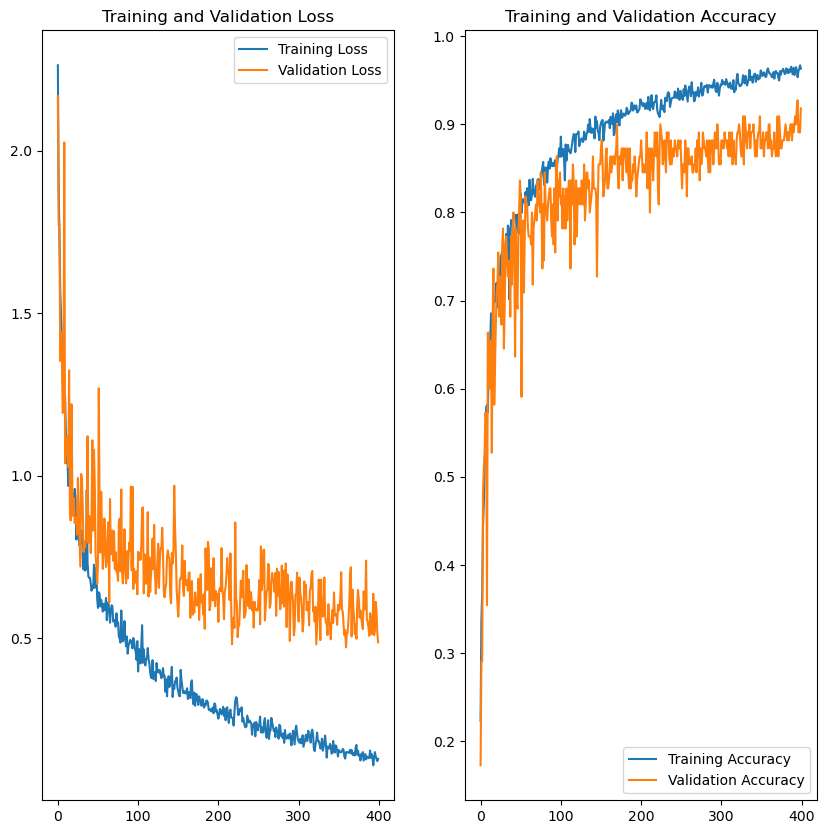

In [ ]:
#Plot the Loss function and the Accuracy curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()


## Performance evaluation

In [ ]:
# Load the test set for the performance evaluation

test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=1,
    shuffle=False,
    image_size=(img_width,img_height)
)


Found 110 files belonging to 12 classes.


In [ ]:
loss,acc = model_div.evaluate(test_ds)


110/110 [==============================] - 5s 42ms/step - loss: 0.4296 - accuracy: 0.9273


In [ ]:
#Store the labels of the test set

labels = []
for _, label in test_ds:
    labels.extend(tf.argmax(label, axis=1).numpy())


In [ ]:
#Store the predictions

predictions = model_div.predict(test_ds)
predictions = tf.argmax(predictions,axis=1).numpy()
predictions


110/110 [==============================] - 5s 44ms/step


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  0,  6,  6,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11,  6,  6,  6,  5,  6])

### Performance for different types of plants

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#The performance for each category

print(classification_report(labels, predictions))



              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00        10
           5       0.88      0.70      0.78        10
           6       0.62      1.00      0.77        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      0.50      0.67        10

    accuracy                           0.93       110
   macro avg       0.95      0.93      0.93       110
weighted avg       0.95      0.93      0.92       110



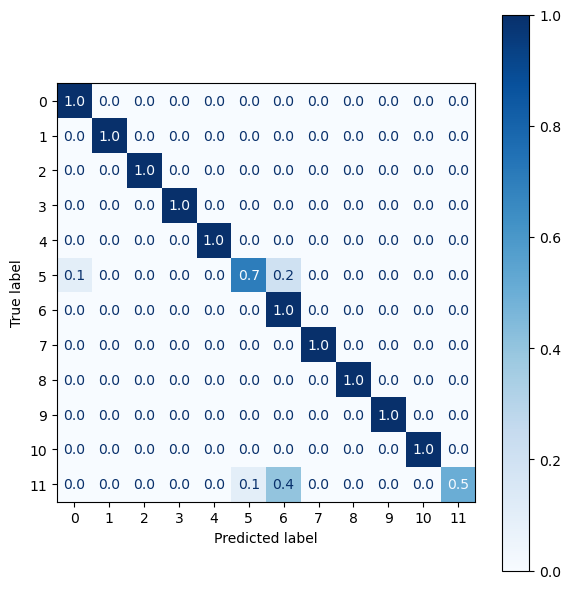

In [ ]:
#Plot a normalized confusion matrix

cm = confusion_matrix(labels, predictions, labels=list(range(0, 12)))

cmap = plt.get_cmap("Blues")

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(6, 6))

display = ConfusionMatrixDisplay(cm, display_labels=list(range(0, 12)))
display.plot(ax=ax, cmap=cmap, values_format=".1f")

plt.tight_layout()
plt.show()

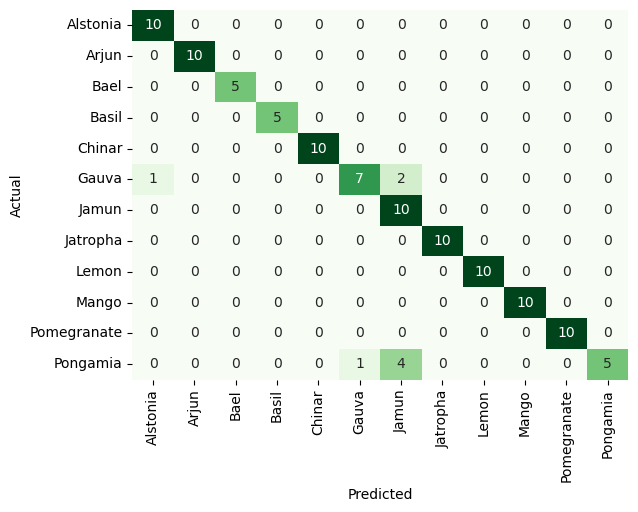

In [ ]:
import seaborn as sns

#Plot a classic confusion matrix

cm=confusion_matrix(labels,predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names,cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Misclassified Images

In [ ]:
#Store the indices of the images that has been misclassified

misc_ind = np.where(predictions != labels)[0]

In [ ]:
misc_ind

array([ 46,  47,  48, 105, 106, 107, 108, 109])

In [ ]:
# Load again the test set to have a better resolution for the images

test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=1,
    color_mode="rgb",
    shuffle=False,
)


Found 110 files belonging to 12 classes.


In [ ]:
#Store again the labels

labels = []
for _, label in test_ds:
    labels.extend(tf.argmax(label, axis=1).numpy())

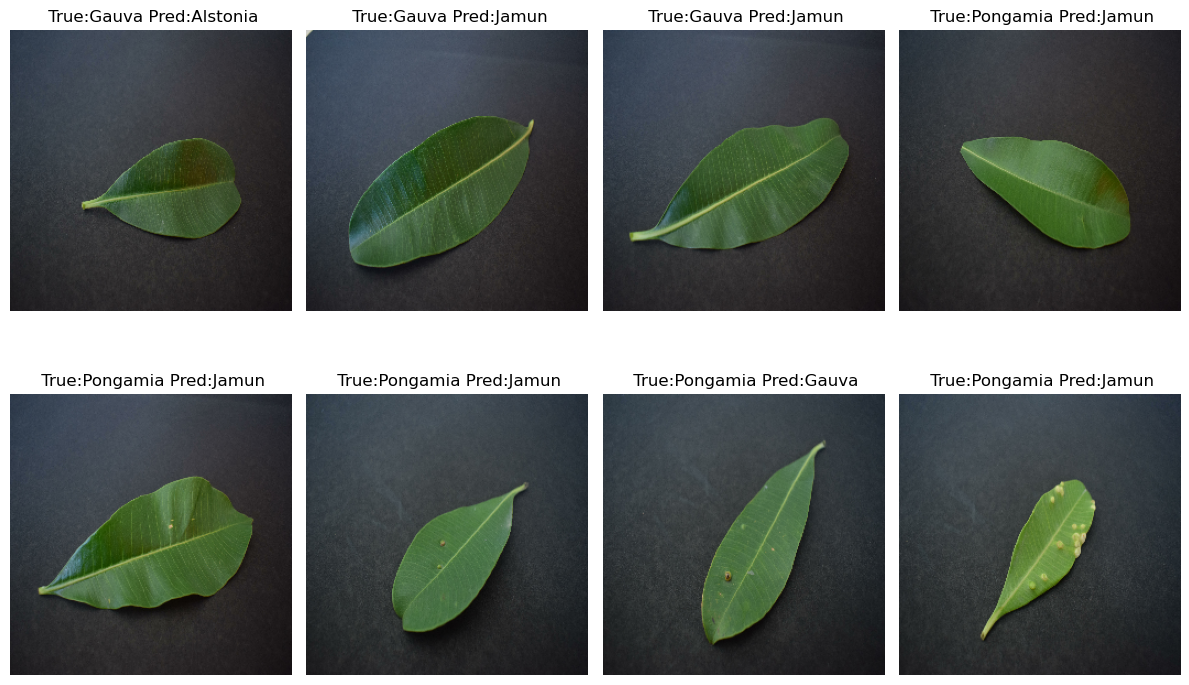

In [ ]:
#Plot the images that have been misclassified by the model


# Set the subplot
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

# Set a counter for the images
index_counter = 0

for (images,_) in test_ds:
    for image in images:
        if index_counter < len(misc_ind):
            idx = misc_ind[index_counter]
            row = index_counter // 4
            col = index_counter % 4

            #Define the position of the images
            axs[row, col].imshow(image.numpy().astype("uint8"))
            axs[row, col].set_title(f" True:{class_names[labels[idx]]} Pred:{class_names[predictions[idx]]}")
            axs[row, col].axis('off')

            index_counter += 1
        else:
            break

    #Break once we plot the last image in the misclassified list
    if index_counter >= len(misc_ind):
        break

# Adjust and plot
plt.tight_layout()
plt.show()

# Second part:  "Health classification"

In [ ]:
#Set a function that merge together healthy leaves and in another forlder diseased leaves

def prepare_health(folder):

    subdirectories = os.listdir(folder)
    if '.DS_Store' in subdirectories:
        subdirectories.remove('.DS_Store')

    diseased_folder = f'{folder}/diseased'
    healthy_folder = f'{folder}/healthy'

    os.makedirs(diseased_folder, exist_ok=True)
    os.makedirs(healthy_folder, exist_ok=True)

    # Loop and move
    for directory in subdirectories:
        source_folder = f'{folder}/{directory}'
        dest_folder = diseased_folder if 'diseased' in directory else healthy_folder

        content = os.listdir(source_folder)

        for item in content:
            source_item = os.path.join(source_folder, item)
            dest_item = os.path.join(dest_folder, item)
            shutil.move(source_item, dest_item)


    #This part delete the empty folders
    folder_to_del= [directory for directory in subdirectories if directory not in ['healthy','diseased'] ]

    for directory in folder_to_del:
        os.rmdir(f'{folder}/{directory}')



In [ ]:
#Adjust both train, validation and test

prepare_health('Health/train')
prepare_health('Health/valid')
prepare_health('Health/test')

## Load the data

In [ ]:
train_ht_dir = "Health/train"
valid_ht_dir = "Health/valid"
test_ht_dir = "Health/test"


In [ ]:
img_height=128
img_width=128
BATCH_SIZE=128


In [ ]:
train_ht_ds=tf.keras.utils.image_dataset_from_directory(
    train_ht_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=True,
    image_size=(img_width,img_height),
    interpolation="bilinear"
)


Found 4274 files belonging to 2 classes.


In [ ]:
valid_ht_ds=tf.keras.utils.image_dataset_from_directory(
    valid_ht_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    shuffle=True,
    image_size=(img_width,img_height),
    interpolation="bilinear"
)


Found 110 files belonging to 2 classes.


In [ ]:
#Check the classes
class_ht_names = train_ht_ds.class_names
print(class_ht_names)


['diseased', 'healthy']


## Model implementation

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ht_ds = train_ht_ds.cache().shuffle(buffer_size=round(4300/BATCH_SIZE)).prefetch(buffer_size=AUTOTUNE)
valid_ht_ds = valid_ht_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1)
  ]
)


In [ ]:
#Define the model, the optimizer, and the loss

model_ht = Sequential([
  layers.Rescaling(1./255, input_shape=(img_width,img_height,3)),
  data_augmentation,
  layers.Conv2D(kernel_size=5,filters=25,activation='relu'),
  layers.AveragePooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(kernel_size=5,filters=50,activation='relu'),
  layers.AveragePooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(kernel_size=5,filters=75,activation='relu'),
  layers.AveragePooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(kernel_size=5,filters=75,activation='relu'),
  layers.AveragePooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(kernel_size=4,filters=100,activation='relu'),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(240,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(120,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(60,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(30,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(12,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(2,activation='softmax')
 ])

model_ht.compile(optimizer=optimizers.legacy.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_ht.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 124, 124, 25)      1900      
                                                                 
 average_pooling2d_3 (Avera  (None, 62, 62, 25)        0         
 gePooling2D)                                                    
                                                                 
 dropout_9 (Dropout)         (None, 62, 62, 25)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 58, 58, 50)        31300     
                                                      

In [ ]:
# Set the learning rate decaying function
def lr_decay(epoch):
 return 0.0012-(epoch*0.000004)

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)


In [ ]:
#Set the number of epochs and train the model

EPOCHS=150
history = model_ht.fit(
  train_ht_ds,
  validation_data=valid_ht_ds,
  epochs=EPOCHS,
  callbacks=([lr_decay_callback])
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0012.
Epoch 1/150


2023-11-02 10:00:19.825307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 203 of 1024
2023-11-02 10:00:29.919506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 377 of 1024
2023-11-02 10:00:39.852000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 603 of 1024
2023-11-02 10:00:49.871431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 833 of 1024
2023-11-02 10:00:58.163278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2023-11-02 10:01:03.857896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1 of 34
2023-11-02 10:01:09.189805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2 of 34
2023-

34/34 [==============================] - 253s 2s/step - loss: 0.6833 - accuracy: 0.5466 - val_loss: 0.6454 - val_accuracy: 0.6182 - lr: 0.0012

Epoch 2: LearningRateScheduler setting learning rate to 0.0011959999999999998.
Epoch 2/150
34/34 [==============================] - 57s 2s/step - loss: 0.6303 - accuracy: 0.6383 - val_loss: 0.5976 - val_accuracy: 0.6273 - lr: 0.0012

Epoch 3: LearningRateScheduler setting learning rate to 0.001192.
Epoch 3/150
34/34 [==============================] - 59s 2s/step - loss: 0.6182 - accuracy: 0.6488 - val_loss: 0.6060 - val_accuracy: 0.6364 - lr: 0.0012

Epoch 4: LearningRateScheduler setting learning rate to 0.0011879999999999998.
Epoch 4/150
34/34 [==============================] - 61s 2s/step - loss: 0.6133 - accuracy: 0.6603 - val_loss: 0.5973 - val_accuracy: 0.6636 - lr: 0.0012

Epoch 5: LearningRateScheduler setting learning rate to 0.001184.
Epoch 5/150
34/34 [==============================] - 62s 2s/step - loss: 0.5702 - accuracy: 0.6926 - 

Epoch 37/150
34/34 [==============================] - 59s 2s/step - loss: 0.2282 - accuracy: 0.9113 - val_loss: 0.4030 - val_accuracy: 0.8727 - lr: 0.0011

Epoch 38: LearningRateScheduler setting learning rate to 0.001052.
Epoch 38/150
34/34 [==============================] - 57s 2s/step - loss: 0.2237 - accuracy: 0.9097 - val_loss: 0.4743 - val_accuracy: 0.8727 - lr: 0.0011

Epoch 39: LearningRateScheduler setting learning rate to 0.0010479999999999999.
Epoch 39/150
34/34 [==============================] - 58s 2s/step - loss: 0.2107 - accuracy: 0.9183 - val_loss: 0.4333 - val_accuracy: 0.8727 - lr: 0.0010

Epoch 40: LearningRateScheduler setting learning rate to 0.0010439999999999998.
Epoch 40/150
34/34 [==============================] - 59s 2s/step - loss: 0.2024 - accuracy: 0.9249 - val_loss: 0.4178 - val_accuracy: 0.8636 - lr: 0.0010

Epoch 41: LearningRateScheduler setting learning rate to 0.00104.
Epoch 41/150
34/34 [==============================] - 60s 2s/step - loss: 0.2042 - 


Epoch 107: LearningRateScheduler setting learning rate to 0.0007759999999999999.
Epoch 107/150
34/34 [==============================] - 58s 2s/step - loss: 0.1314 - accuracy: 0.9506 - val_loss: 0.3403 - val_accuracy: 0.9273 - lr: 7.7600e-04

Epoch 108: LearningRateScheduler setting learning rate to 0.0007719999999999999.
Epoch 108/150
34/34 [==============================] - 58s 2s/step - loss: 0.1313 - accuracy: 0.9502 - val_loss: 0.4210 - val_accuracy: 0.9091 - lr: 7.7200e-04

Epoch 109: LearningRateScheduler setting learning rate to 0.0007679999999999999.
Epoch 109/150
34/34 [==============================] - 59s 2s/step - loss: 0.1183 - accuracy: 0.9579 - val_loss: 0.4364 - val_accuracy: 0.8818 - lr: 7.6800e-04

Epoch 110: LearningRateScheduler setting learning rate to 0.0007639999999999999.
Epoch 110/150
34/34 [==============================] - 61s 2s/step - loss: 0.1198 - accuracy: 0.9534 - val_loss: 0.3838 - val_accuracy: 0.9091 - lr: 7.6400e-04

Epoch 111: LearningRateSchedule

Epoch 141/150
34/34 [==============================] - 59s 2s/step - loss: 0.1010 - accuracy: 0.9612 - val_loss: 0.3625 - val_accuracy: 0.9273 - lr: 6.4000e-04

Epoch 142: LearningRateScheduler setting learning rate to 0.000636.
Epoch 142/150
34/34 [==============================] - 59s 2s/step - loss: 0.1292 - accuracy: 0.9509 - val_loss: 0.3499 - val_accuracy: 0.9091 - lr: 6.3600e-04

Epoch 143: LearningRateScheduler setting learning rate to 0.000632.
Epoch 143/150
34/34 [==============================] - 59s 2s/step - loss: 0.1142 - accuracy: 0.9520 - val_loss: 0.3127 - val_accuracy: 0.9273 - lr: 6.3200e-04

Epoch 144: LearningRateScheduler setting learning rate to 0.0006279999999999999.
Epoch 144/150
34/34 [==============================] - 61s 2s/step - loss: 0.1061 - accuracy: 0.9619 - val_loss: 0.3589 - val_accuracy: 0.9273 - lr: 6.2800e-04

Epoch 145: LearningRateScheduler setting learning rate to 0.0006239999999999999.
Epoch 145/150
34/34 [==============================] - 59s

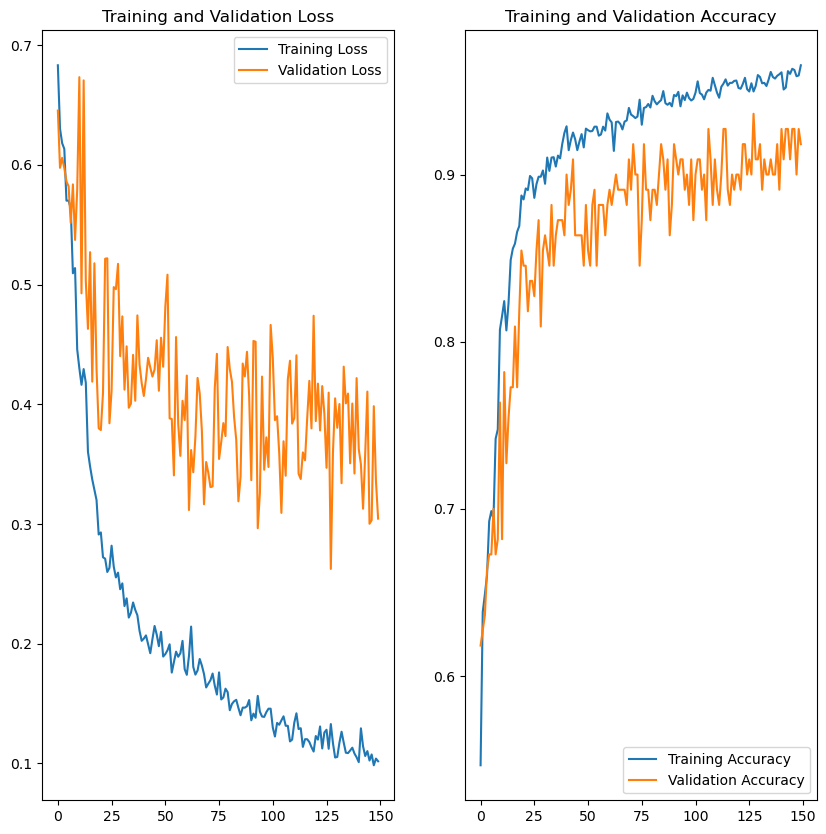

In [ ]:
#Plot the loss function curves and the accuracy ones

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()


## Performance evaluation

In [ ]:
#Load the test set

test_ht_ds=tf.keras.utils.image_dataset_from_directory(
    test_ht_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=1,
    shuffle=False,
    color_mode="rgb",
    image_size=(128,128)
)


Found 110 files belonging to 2 classes.


In [ ]:
model_ht.evaluate(test_ht_ds)


110/110 [==============================] - 6s 47ms/step - loss: 0.3518 - accuracy: 0.8909


[0.35175612568855286, 0.8909090757369995]

In [ ]:
#Store the labels
labels = []
for _, label in test_ht_ds:
    labels.extend(tf.argmax(label, axis=1).numpy())


In [ ]:
#Store the predictions
predictions_ht = model_ht.predict(test_ht_ds)
predictions_ht = tf.argmax(predictions_ht,axis=1).numpy()
predictions_ht


110/110 [==============================] - 6s 48ms/step


array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

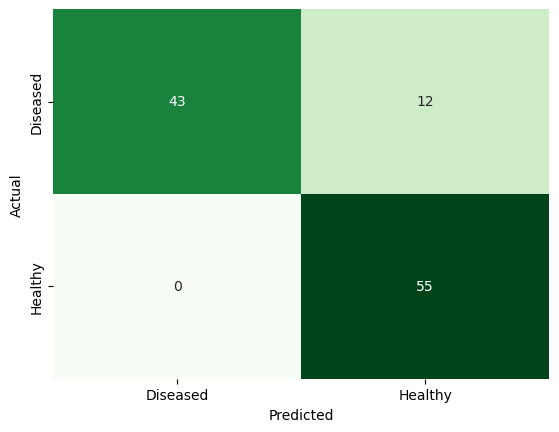

In [ ]:
#Plot a confusion matrix
import seaborn as sns

confusion = confusion_matrix(labels, predictions_ht)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Greens', xticklabels=['Diseased','Healthy'], yticklabels=['Diseased','Healthy'],cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Images/Image8')
plt.show()

## Misclassified images

In [ ]:
misc_ind = np.where(predictions_ht != labels)[0]

In [ ]:
misc_ind

array([ 3,  5,  8, 13, 14, 25, 30, 45, 46, 47, 49, 52])

In [ ]:
#Load again the test set for a better resolution

test_ht_ds=tf.keras.utils.image_dataset_from_directory(
    test_ht_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=1,
    shuffle=False,
    color_mode="rgb"
)

Found 110 files belonging to 2 classes.


In [ ]:
#Store again the labels
labels = []
for _, label in test_ht_ds:
    labels.extend(tf.argmax(label, axis=1).numpy())

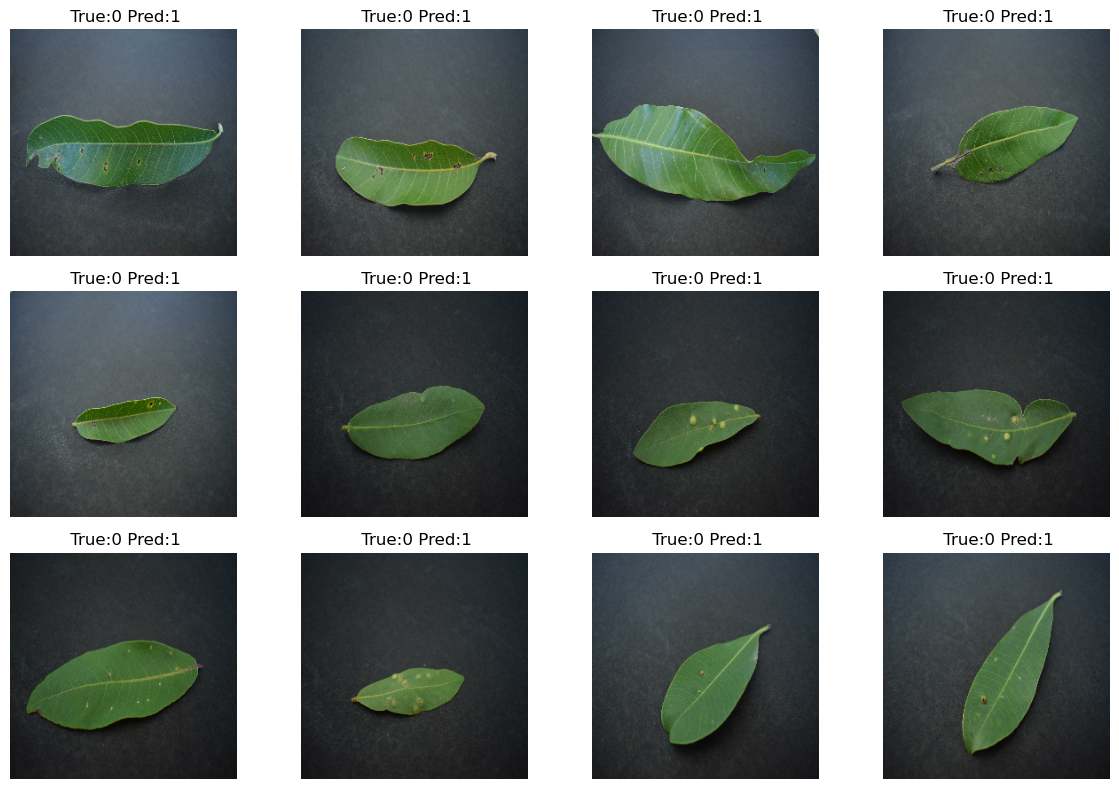

In [ ]:

# Set a subplot
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

# Set a counter
index_counter = 0

for (images,_) in test_ht_ds:
    for image in images:
        if index_counter < len(misc_ind):
            idx = misc_ind[index_counter]
            row = index_counter // 4
            col = index_counter % 4

            axs[row, col].imshow(image.numpy().astype("uint8"))
            axs[row, col].set_title(f" True:{labels[idx]} Pred:{predictions_ht[idx]}")
            axs[row, col].axis('off')

            index_counter += 1
        else:
            break

    # Break once that the last misclassified image has been plotted
    if index_counter >= len(misc_ind):
        break

# Adjust and plot
plt.tight_layout()
plt.show()